In [1]:
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import L_BFGS_B, SPSA
from qiskit.primitives import Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit import QuantumCircuit

In [61]:
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.725",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

In [62]:
mapper = JordanWignerMapper()

In [63]:
print("Hamiltonian of Molecule:")
hamiltonian = es_problem.hamiltonian.second_q_op()
qubit_op = mapper.map(hamiltonian)
aux_op = mapper.map(es_problem.second_q_ops()[1])
for pauli, coeff in sorted(qubit_op.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")

Hamiltonian of Molecule:
-0.80718366 * IIII
+0.17374013 * IIIZ
-0.23047453 * IIZI
+0.12148839 * IIZZ
+0.17374013 * IZII
+0.16940471 * IZIZ
+0.16658220 * IZZI
+0.04509381 * XXXX
+0.04509381 * XXYY
+0.04509381 * YYXX
+0.04509381 * YYYY
-0.23047453 * ZIII
+0.16658220 * ZIIZ
+0.17510657 * ZIZI
+0.12148839 * ZZII


Building a noise model based on T1, T2 relaxation times, as well as gate time
https://www.researchgate.net/figure/The-gate-times-in-ns-for-all-supported-one-and-two-qubit-quantum-gates_tbl1_259212249

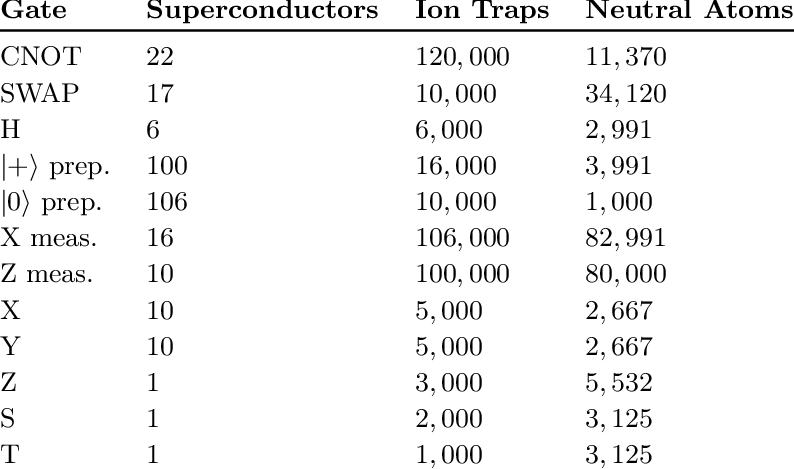

In [55]:
from IPython.display import Image
Image(filename='gate_time.png')

In [29]:
import numpy as np
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error)

In [72]:
class ThermalNoiseModel(NoiseModel):
    def __init__(self, t1, t2):
        super().__init__()
        self.t1 = t1
        self.t2 = t2
        self.time_cx = 22
        self.time_swap = 17
        self.single_gate_times = {
            "h": 6,
            "x": 10,
            "y": 10,
            "measure": 10
        }

        self.add_errors()

    def add_errors(self):
        for gate, time in self.single_gate_times.items():
            self.add_all_qubit_quantum_error(thermal_relaxation_error(self.t1, self.t2, time), gate)
        self.add_all_qubit_quantum_error(thermal_relaxation_error(self.t1, self.t2, self.time_cx).expand(thermal_relaxation_error(self.t1, self.t2, self.time_cx)), "cx")
        self.add_all_qubit_quantum_error(thermal_relaxation_error(self.t1, self.t2, self.time_swap).expand(thermal_relaxation_error(self.t1, self.t2, self.time_swap)), "swap")

In [80]:
seed = 100

noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": [(0, 1), (1, 2), (2, 3), (3, 4)],
        "noise_model": ThermalNoiseModel(80e3, 120e3),
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed}
)

In [81]:
ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

vqe_solver = VQE(noisy_estimator, ansatz, SPSA()) #, callback=store_intermediate_result)
vqe_solver.initial_point = [0.0] * ansatz.num_parameters

## Ansatz Circuit & Gates

In [46]:
for gate, cnt in ansatz.decompose(reps=3).count_ops().items():
    print(f"{gate.upper()} Gate - {cnt}")

H Gate - 80
CX Gate - 56
SDG Gate - 20
S Gate - 20
RZ Gate - 12
U Gate - 2


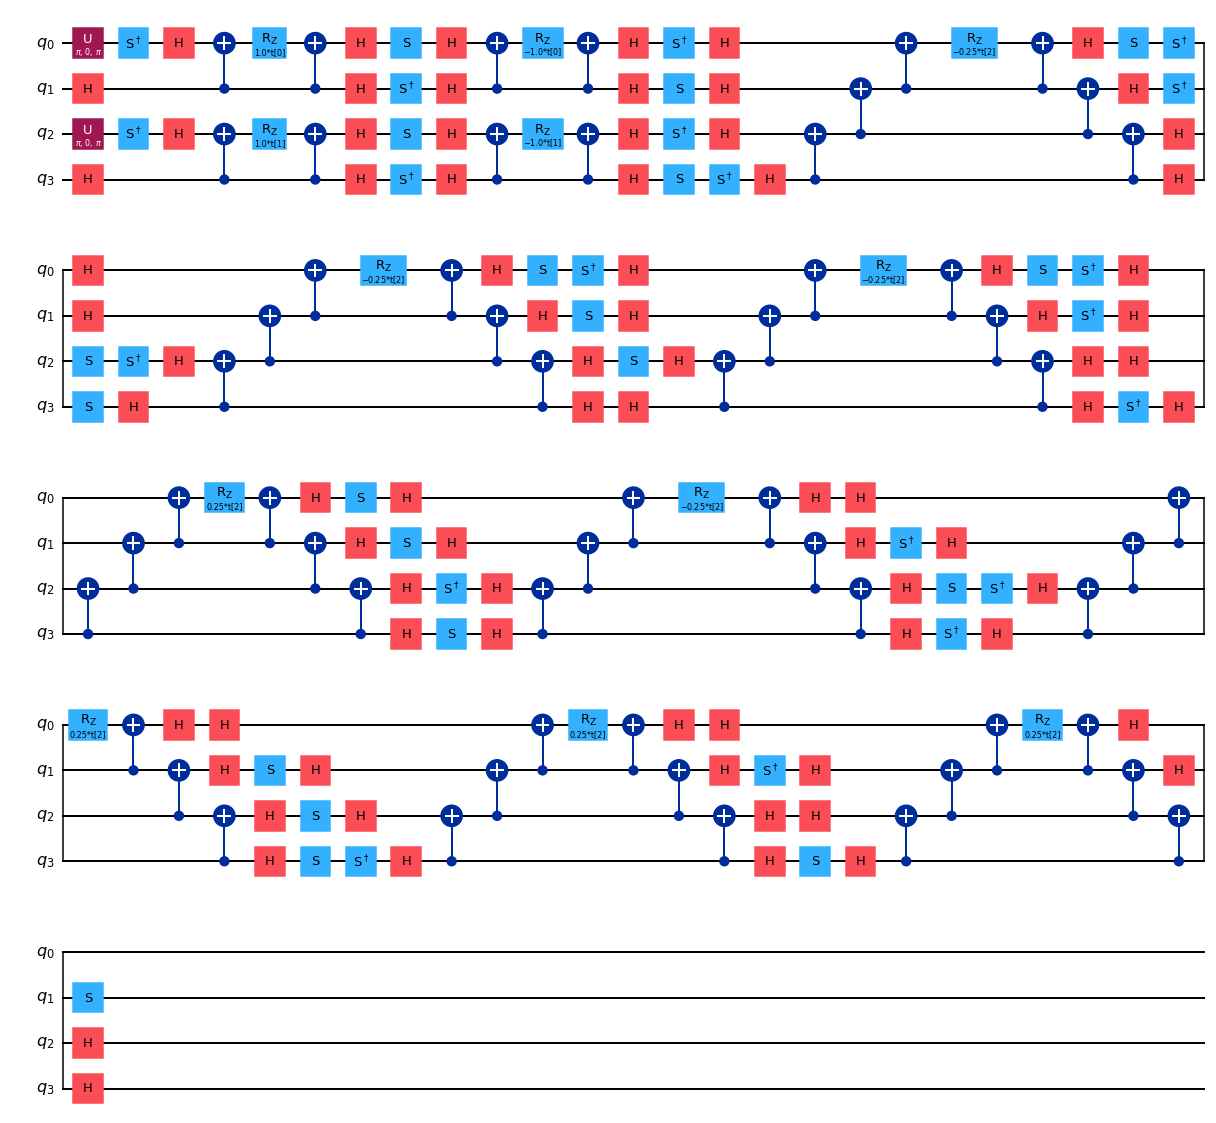

In [38]:
ansatz.decompose(reps=3).draw(output="mpl")

In [8]:
for excitation in ansatz._excitation_list:
    print(f"{excitation[0]} => {excitation[1]}")

(0,) => (1,)
(2,) => (3,)
(0, 2) => (1, 3)


Run the VQE

In [82]:
raw_result = vqe_solver.compute_minimum_eigenvalue(qubit_op, aux_op)
res = es_problem.interpret(raw_result)
res.total_energies[0]

-0.9261010006214742

In [83]:
calculated = res.eigenvalues[0] + res._nuclear_repulsion_energy
actual = res._hartree_fock_energy
print("Total Calculated Energy:", calculated)
print("Actual Energy:", res._hartree_fock_energy)
print(f"Percentage Error: {(calculated - actual) / calculated * 100:.2f}%")

Total Calculated Energy: -0.9261010006214742
Actual Energy: -0.6148699740425608
Percentage Error: 33.61%


In [78]:
distances = np.hstack((np.arange(0.2, 1.55, 0.05), np.arange(1.75, 4.25, 0.25)))
vqe_energies = []

for distance in tqdm(distances, desc="Calculating energies"):
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    es_problem = driver.run()
    qubit_op, aux_op = es_problem.second_q_ops()
    qubit_op, aux_op = mapper.map(qubit_op), mapper.map(aux_op)
    raw_result = vqe_solver.compute_minimum_eigenvalue(qubit_op, aux_op)
    res = es_problem.interpret(raw_result)
    vqe_energies.append(res.total_energies[0])

Calculating energies: 100%|██████████| 37/37 [01:16<00:00,  2.07s/it]


In [84]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

interpolated_function = interp1d(distances, vqe_energies, kind='cubic')
result = minimize_scalar(interpolated_function, bounds=(distances.min(), distances.max()), method='bounded')

min_distance = result.x
min_energy = result.fun
print(f"The distance that minimizes the energy is: {min_distance} Å")
print(f"The minimum energy is: {min_energy} Hartree")
# -0.98 hartree minimum energy for noisy
# -1.11 for noiseless

The distance that minimizes the energy is: 0.7141707697442655 Å
The minimum energy is: -1.1375112371064615 Hartree


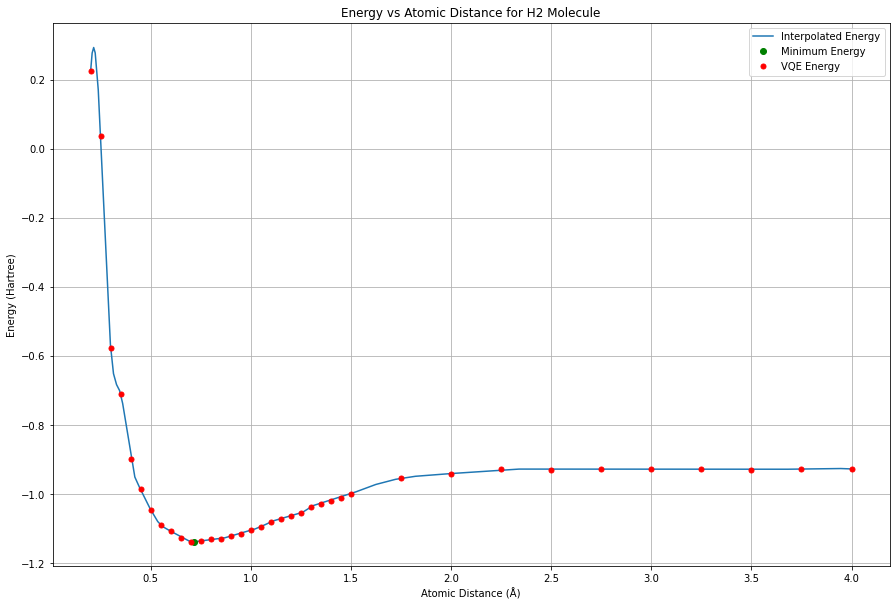

In [85]:
fine_distances = np.linspace(distances.min(), distances.max(), 500)
interpolated_energies = interpolated_function(fine_distances)
plt.figure(figsize=(15, 10))
plt.style.use('fast')
plt.plot(fine_distances, interpolated_energies, label='Interpolated Energy')
plt.plot(min_distance, min_energy, 'go', label='Minimum Energy')
plt.plot(distances, vqe_energies, marker='o', color='red', linestyle='', markersize=5, label='VQE Energy')
plt.xlabel('Atomic Distance (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy vs Atomic Distance for H2 Molecule')
plt.grid(True)
plt.legend()
plt.show()

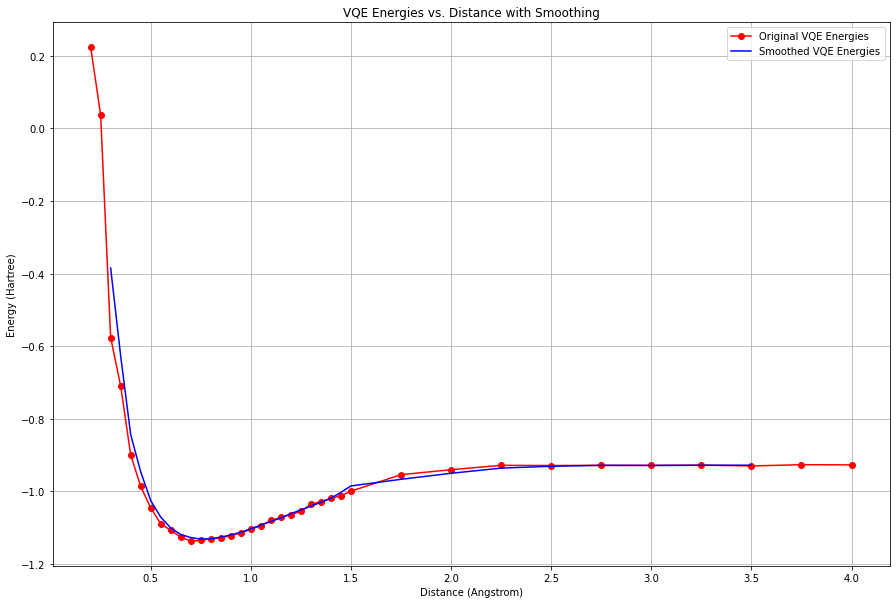

The minimum energy is -1.131471 Hartree at a distance of 0.750000 Angstrom


In [86]:
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size

# Apply convolution to smooth the energies
smoothed_energies = np.convolve(vqe_energies, kernel, mode='valid')

# Adjust distances to match the length of the smoothed energies
adjusted_distances = distances[(kernel_size-1)//2:-(kernel_size-1)//2] if kernel_size % 2 != 0 else distances[(kernel_size)//2:-(kernel_size)//2]

# Plot the original and smoothed energies
plt.figure(figsize=(15, 10))
plt.plot(distances, vqe_energies, 'o-', label='Original VQE Energies', color='red')
plt.plot(adjusted_distances, smoothed_energies, '-', label='Smoothed VQE Energies', color='blue')

plt.xlabel('Distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('VQE Energies vs. Distance with Smoothing')
plt.legend()
plt.grid(True)
plt.show()

print(f"The minimum energy is {smoothed_energies.min():.6f} Hartree at a distance of {adjusted_distances[smoothed_energies.argmin()]:.6f} Angstrom")

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


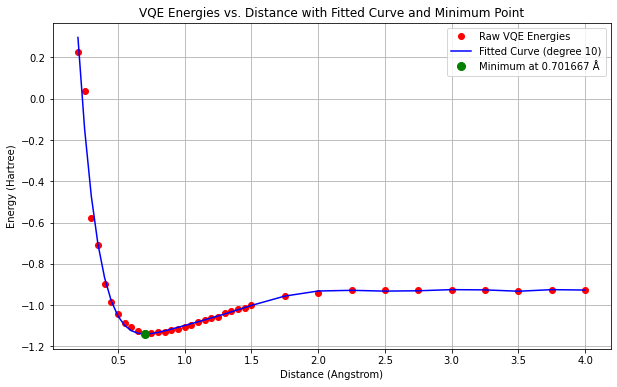

The minimum energy is -1.139874 Hartree at a distance of 0.701667 Angstrom


In [87]:
degree = 10  # Degree of the polynomial
coefficients = np.polyfit(distances, vqe_energies, degree)
fitted_curve = np.polyval(coefficients, distances)

critical_points = list(filter(lambda x: not np.iscomplex(x) and np.min(distances) <= x <= np.max(distances),
                              np.roots(np.polyder(coefficients))))
min_distance = critical_points[np.argmin(np.polyval(coefficients, critical_points))]
min_energy = np.polyval(coefficients, min_distance)

# Plot the raw data and the fitted curve
plt.figure(figsize=(10, 6))
plt.plot(distances, vqe_energies, 'o', label='Raw VQE Energies', color='red')
plt.plot(distances, fitted_curve, '-', label=f'Fitted Curve (degree {degree})', color='blue')
plt.plot(min_distance, min_energy, 'go', label=f'Minimum at {min_distance.real:.6f} Å', markersize=8)

plt.xlabel('Distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('VQE Energies vs. Distance with Fitted Curve and Minimum Point')
plt.legend()
plt.grid(True)
plt.show()

print(f"The minimum energy is {min_energy.real:.6f} Hartree at a distance of {min_distance.real:.6f} Angstrom")